Facing a challenge of pushing the performance to match the baseline, let alone beat it, with the neural network designed for a multi-class classification, we decided to split the dataset into multiple classification problems and fit a binary classifier to each of them following a one-vs-all strategy. To achieve that we implemented the following framework:
1. Calculate class weights in the original training set
2. Select one target class out of 10 available ones and remap it as a positive class for binary classification (1)
3. Rebalance all classes using a combination of  SMOTE and undersampling with a goal of having a ratio between the new target class from #2 being equal to or very close to the ratio of all other classes.
4. “Collapse” all remaining classes into one large negative class for binary classification
5. Calculate resulting class weight to pass to the model
Fit the model on the remapped and rebalanced binary training set

We then repeated that process 10 times to create a class-specific binary classifier for each of the attack classes and one non-attack (normal) class and combined them into a voting classifier. The voting classifier was then able to beat the baseline by 4.56% and achieve a balanced accuracy of 77.24% on the train set. As you could see in the plot on Fig.9, that model has significant improvements in its ability to identify “analysis” (+51%) and “backdoor” (+32%) attack types. These gains, however, come at the expense of decrease in performance for other classes: “DoS” (-7%), “shellcode” (-5%), “worms” (-16%).





In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May 23 17:44:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


### Load the Data

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import process_time
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score 
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
print(imblearn.__version__)


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

0.10.1


In [4]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [5]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [6]:
# uncomment if running in Colab - only loading the data for multi-class case
!gdown '1ICZUG9vdJKSWjS1Ojr_Vb3VKgONeTXX1' -O train_imbalanced_85.csv
!gdown '1F1mHLwlno3OOtpSpMsiQqhoow6aj__DN' -O test_imbalanced_15.csv

Downloading...
From: https://drive.google.com/uc?id=1ICZUG9vdJKSWjS1Ojr_Vb3VKgONeTXX1
To: /content/train_imbalanced_85.csv
100% 237M/237M [00:09<00:00, 23.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1F1mHLwlno3OOtpSpMsiQqhoow6aj__DN
To: /content/test_imbalanced_15.csv
100% 41.8M/41.8M [00:02<00:00, 20.2MB/s]


In [7]:
# Colab
train = pd.read_csv('train_imbalanced_85.csv') # 22 features Colab
test = pd.read_csv('test_imbalanced_15.csv') # Colab

In [12]:
# check the count of instances of each class
train.attack_cat_code.value_counts()

0    1885684
1     183159
2      37846
3      20609
4      13900
5      11889
6       2275
7       1980
8       1284
9        148
Name: attack_cat_code, dtype: int64

#### Function to vizualize predictions


In [14]:
# get the labels
codes = {'Normal':0,
         'Generic':1,
         'Exploits':2,
         'Fuzzers': 3,
         'DoS':4,
         'Reconnaissance':5,
         'Analysis':6,
         'Backdoor':7,
         'Shellcode':8,
         'Worms':9   
}
labels = [x for x in codes.keys()]

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

def calculate_metrics(y_true, y_pred, labels):


    """
    Calculate main metrics:
    :param y_test - actual value
    :param y_pred - predicted value
    :param labels - class labels
    :return balanced_accuracy, accuracy, precision, recall, f1
    """
    accuracy = accuracy_score(y_true, y_pred)
    # The balanced accuracy in binary and multiclass classification problems to deal with imbalanced datasets. 
    # It is defined as the average of recall obtained on each class.
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)

    # tp / (tp + fp) Ability of the classifier not to label as positive a sample that is negative.
    precision = precision_score(y_true, y_pred, average='weighted')

    # tp / (tp + fn) Ability of the classifier to find all the positive samples.
    recall = recall_score(y_true, y_pred, average='weighted')

    # F1 = 2 * (precision * recall) / (precision + recall)
    # harmonic mean of the precision and recall
    f1 = f1_score(y_true, y_pred, average='weighted')


    print(f'Accuracy:{accuracy:.2f}')
    print(f'Balanced accuracy:{balanced_accuracy:.2f}')
    print(f'Precision:{precision:.2f}')
    print(f'Recall:{recall:.2f}')
    print(f'F1-score:{f1:.2f}') 

    cnf_matrix = confusion_matrix(y_true, y_pred, normalize='true')

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title('Balanced Accuracy on Test Set: {0}%\n'.format("%.2f" % (balanced_accuracy*100.0)), size=14)
    ax.set_ylabel('Actual Label')
    ax.set_xlabel('Predicted Label')

    sns.heatmap(cnf_matrix,
              square=True,
              annot=True,
              cbar=False,
              fmt=".2f",
              linewidths=0.1,
              cmap="Greens",
              xticklabels=labels,
              yticklabels=labels,
              ax=ax)
    plt.tight_layout()
    plt.xticks(size=10)
    plt.yticks(size=10)
    plt.show()

    print('Classification Report:\n',
      classification_report(y_true,
                            y_pred,
                            target_names=labels))
    return accuracy, balanced_accuracy, precision, recall, f1 

### Class-specific Classifiers: Automating with functions

In [123]:
def create_model(X_tr, y_tr, Xv, yv, class_weights_):
  tf.keras.backend.clear_session()
  inputs = keras.Input(shape=(22,))

  features = layers.Dense(256, activation="relu")(inputs)
  features = layers.Dropout(0.5)(features)
  features = layers.Dense(128, activation="relu")(features)
  features = layers.Dropout(0.5)(features)

  outputs = layers.Dense(2, activation="softmax")(features)

  model = keras.Model(inputs=inputs, outputs=outputs)

  # compile the model
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

  history = model.fit(X_tr, 
                    y_tr,
                    epochs=15,
                    batch_size=1024,
                    validation_data=(Xv, yv),
                    class_weight = class_weights_)
  
  return history, model

In [121]:
def plot_training(history_object):

  val_acc = history_object.history["val_accuracy"]
  train_acc = history_object.history["accuracy"]

  val_loss = history_object.history["val_loss"]
  train_loss = history_object.history["loss"]

  epochs = range(1, len(val_acc)+1)
  fig, ax = plt.subplots(figsize=(12, 6))

  plt.subplot(2, 2, 1)
  plt.title("Validation Loss")
  plt.plot(epochs, val_loss, "o-", label="Validation Loss")

  plt.subplot(2, 2, 2)
  plt.title("Training Loss")
  plt.plot(epochs, train_loss, label="Training Loss", color = 'orange')

  plt.subplot(2, 2, 3)
  plt.title("Validation accuracy")
  plt.plot(epochs, val_acc, "o-", label="Validation accuracy")

  plt.subplot(2, 2, 4)
  plt.title("Training accuracy")
  plt.plot(epochs, train_acc,  label="Training accuracy", color = 'orange')
  plt.tight_layout()
  plt.legend()

### Preprocess the data


In [109]:
# create X and y dataframes
X_train = train.drop('attack_cat_code', axis=1)
y_train = train['attack_cat_code']

X_test = test.drop('attack_cat_code', axis=1)
y_test = test['attack_cat_code']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [110]:
# Setting aside 25% for validation
# splitting into train and val
X_train, X_val, y_train, y_val, = train_test_split(
    X_train, 
    y_train, 
    test_size=0.20, 
    random_state=42, 
    stratify=y_train)

In [111]:
######## resampling
# get count of unique labels in the training fold
unique, counts = np.unique(y_train, return_counts=True)
counts = dict(zip(unique, counts))
print(f'Original counts:\n{counts}') #{0: 1470833, 1: 142864, 2: 29520, 3: 16075, 4: 10842, 5: 9273, 6: 1775, 7: 1544, 8: 1002, 9: 115}

Original counts:
{0: 1508547, 1: 146527, 2: 30277, 3: 16487, 4: 11120, 5: 9511, 6: 1820, 7: 1584, 8: 1027, 9: 119}


In [112]:
target_ratio = {0: 9000,
              1: 9000,
              2: 9000,
              3: 9000,
              4: 9000,
              5: 9000,
              6: counts[6],
              7: counts[7], 
              8: counts[8],
              9: counts[9] }

# UNDERSAMPLE large classes to 10k
rus = RandomUnderSampler(sampling_strategy = target_ratio,
                        replacement = False)

X_train_ds, y_train_ds = rus.fit_resample(X_train, y_train)

y_train_ds.value_counts()

0    9000
1    9000
2    9000
3    9000
4    9000
5    9000
6    1820
7    1584
8    1027
9     119
Name: attack_cat_code, dtype: int64

In [113]:
target_ratio2 = {0: 9000,
              1: 9000,
              2: 9000,
              3: 9000,
              4: 9000,
              5: 9000,
              6: counts[6],
              7: counts[7], 
              8: counts[8],
              9: 1000 } # bringing to at least 1k datapoints

sm = SMOTE(sampling_strategy = target_ratio2)

# APPLY SMOTE on the train folds
X_train_05, y_train_05 = sm.fit_resample(X_train_ds,
                                         y_train_ds)
y_train_05.value_counts()

0    9000
1    9000
2    9000
3    9000
4    9000
5    9000
6    1820
7    1584
8    1027
9    1000
Name: attack_cat_code, dtype: int64

## Models for classes 0 through 5
We now could iterate through classes 0 through 5 selecting all of the data points from the main (positive) class, downsampling the rest to 1k, and collapsing them into a negative class

In [125]:
# create empty lists to store the results
histories = []
models = []
# creating a dataframe to store predictions
all_preds = pd.DataFrame(np.zeros((len(y_test), 10),dtype=float), columns=[i for i in range(10)])

# get the count of classes
unique, counts = np.unique(y_train_05, return_counts=True)
counts = dict(zip(unique, counts))
print(f'Original counts:\n{counts}') # {0: 9000, 1: 9000, 2: 9000, 3: 9000, 4: 9000, 5: 9000, 6: 1820, 7: 1584, 8: 1027, 9: 1000}

# loop to dynamically change the ratio of datapoints between classes
for current_label in range(6):
  # create empty dict for target ratio between classes
  target_ratio = {}
  # remember current classs
  target_class = current_label
  print(f'Current label: {target_class}')
  for cl in range (10):
    if cl == target_class:
      # print(target_class, counts[target_class])
      target_ratio[target_class] = counts[target_class]
    else:
      # print(cl, 1000)
      target_ratio[cl] = 1000

  print(f'Target ratio for class {target_class} is:\n{target_ratio}')

  # UNDERSAMPLE minority classes according to the target ratio
  rus05 = RandomUnderSampler(sampling_strategy = target_ratio,
                        replacement = False)

  X_train_05_ds, y_train_05_ds = rus05.fit_resample(X_train_05, y_train_05)


  ### mapping attack classes to binary case using current target_class as positive
  y_train_05_bin = y_train_05_ds.apply(lambda x: 1 if x== target_class else 0)
  
  # repeating for the validation set
  mapper = lambda x: 1 if x== 0 else 0
  y_val_bin = np.array([mapper(x) for x in y_val])

  print(X_train_05_ds.shape, y_train_05_bin.shape)
 

  # standardize the data
  stdsc = StandardScaler()
  # fit and transform train
  X_train_std_ = stdsc.fit_transform(X_train_05_ds)

  # only transform test and val
  X_test_std_ = stdsc.transform(X_test)
  X_val_std_ = stdsc.transform(X_val)

  # convert to float32
  X_train_std_ = np.asarray(X_train_std_).astype('float32')
  X_test_std_ = np.asarray(X_test_std_).astype('float32')
  X_val_std_ = np.asarray(X_val_std_).astype('float32')

  # convert to float32 and reshape
  y_train_ = np.asarray(y_train_05_bin).astype('float32').reshape((-1,1))
  y_val_ = np.asarray(y_val_bin).astype('float32').reshape((-1,1))
  y_test_ = np.asarray(y_test).astype('float32').reshape((-1,1))

  print(X_train_std_.shape, y_train_.shape)
  print(X_val_std_.shape, y_val_.shape)
  print(X_test_std_.shape, y_test_.shape)

  # calculate final class weights after completing the above steps
  class_weights = {}
  for val in np.unique(y_train_):
      rows = y_train_[y_train_ == val].shape[0]
      total = y_train_.shape[0]
      weight = (1 / rows) * (total / 2.0)
      
      class_weights[val] = weight
  print(f'Class weights: {class_weights}\n')

  print(X_train_std_.shape, y_train_.shape)
  # break
  # fit the model
  history, model = create_model(X_train_std_, 
                                y_train_, 
                                X_val_std_,
                                y_val_,
                                class_weights)

  # record the results
  histories.append(history) 
  models.append(model)

  #generate predictions
  y_pred = model.predict(X_test_std_)
  # record predictions for the current model
  all_preds[target_class] = y_pred[:,1]

Original counts:
{0: 9000, 1: 9000, 2: 9000, 3: 9000, 4: 9000, 5: 9000, 6: 1820, 7: 1584, 8: 1027, 9: 1000}
Current label: 0
Target ratio for class 0 is:
{0: 9000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}
(18000, 22) (18000,)
(18000, 22) (18000, 1)
(431755, 22) (431755, 1)
(380961, 22) (380961, 1)
Class weights: {0.0: 1.0, 1.0: 1.0}

(18000, 22) (18000, 1)
Epoch 1/15
18/18 [==============================] - 2s 67ms/step - loss: 0.4259 - accuracy: 0.8374 - val_loss: 0.1820 - val_accuracy: 0.9755
Epoch 2/15
18/18 [==============================] - 1s 65ms/step - loss: 0.1431 - accuracy: 0.9689 - val_loss: 0.1030 - val_accuracy: 0.9828
Epoch 3/15
18/18 [==============================] - 1s 52ms/step - loss: 0.0902 - accuracy: 0.9817 - val_loss: 0.0852 - val_accuracy: 0.9838
Epoch 4/15
18/18 [==============================] - 1s 46ms/step - loss: 0.0794 - accuracy: 0.9852 - val_loss: 0.0672 - val_accuracy: 0.9838
Epoch 5/15
18/18 [===================

### 0-5 results

In [128]:
all_preds.head()

,0,1,2,3,4,5,6,7,8,9
0,0.999738,0.010548,0.251219,5.205778e-22,0.309575,2.340800e-06,0.0,0.0,0.0,0.0
1,0.996770,0.000966,0.034098,4.018041e-03,0.061152,2.113172e-02,0.0,0.0,0.0,0.0
2,0.999994,0.000152,0.002662,3.215770e-10,0.002680,1.977394e-11,0.0,0.0,0.0,0.0
3,0.998479,0.004829,0.014128,8.306607e-05,0.002247,6.183665e-05,0.0,0.0,0.0,0.0
4,0.999981,0.000601,0.004147,1.090044e-07,0.003458,2.647040e-07,0.0,0.0,0.0,0.0


<ipython-input-121-0fafdbf50865>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


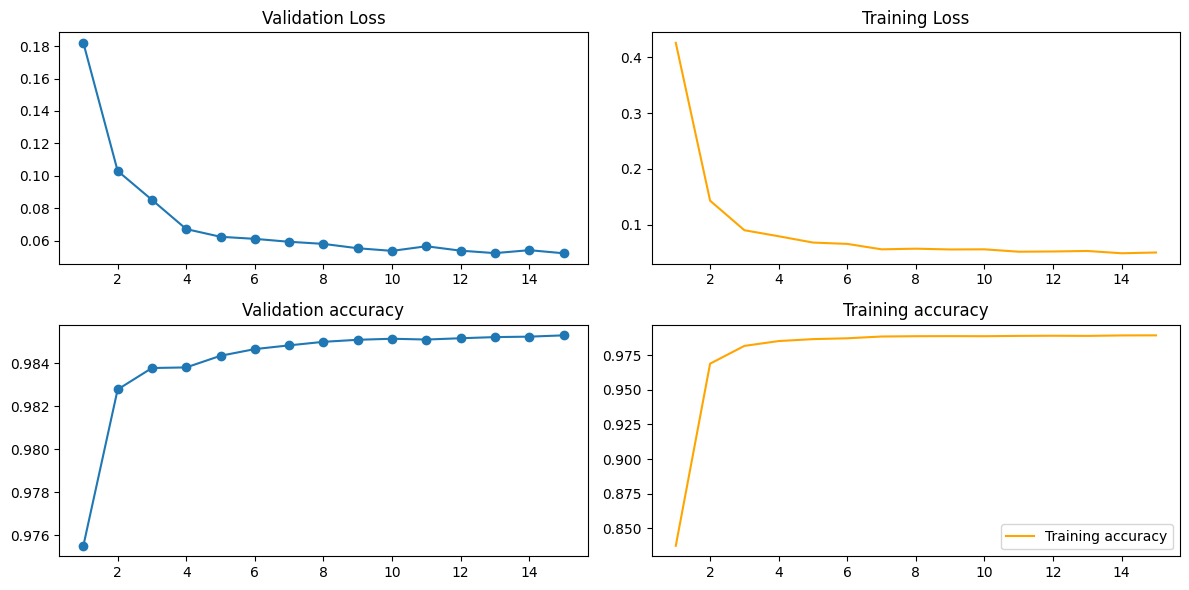

In [129]:
for hist in histories:
  plot_training(hist)
  break

## Models for other classes

#### Class 6

In [ ]:
# create X and y dataframes
X_train = train.drop('attack_cat_code', axis=1)
y_train = train['attack_cat_code']

X_test = test.drop('attack_cat_code', axis=1)
y_test = test['attack_cat_code']

######### resampling
# get count of unique labels in the training fold
unique, counts = np.unique(train.attack_cat_code, return_counts=True)
counts = dict(zip(unique, counts))
print(f'Original counts:\n{counts}') # {0: 29600, 1: 15097, 2: 8905, 3: 4850, 4: 3271, 5: 2797, 6: 542, 7: 467, 8: 302, 9: 35}

# GET INITIAL LABEL COUNT
# get the count for the second largest label of #1 
# this will be the target ratio for upsamling the resto of the labels
zero = counts[0] 
one = counts[1]
two = counts[2]
target_ratio = {0: counts[3],
              1: counts[3],
              2: counts[2],
              3: counts[3],
              4: counts[4],
              5: counts[5],
              6: counts[6],
              7: counts[7], 
              8: counts[8],
              9: counts[9] }


# UNDERSAMPLE the majority class to match the rest of the labels
rus = RandomUnderSampler(sampling_strategy = target_ratio,
                        replacement = False)

X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

y_train_resampled.value_counts()

Original counts:
{0: 1885684, 1: 183159, 2: 37846, 3: 20609, 4: 13900, 5: 11889, 6: 2275, 7: 1980, 8: 1284, 9: 148}


2    37846
0    20609
1    20609
3    20609
4    13900
5    11889
6     2275
7     1980
8     1284
9      148
Name: attack_cat_code, dtype: int64

In [ ]:
# # get count of unique labels in the training fold
# unique, counts = np.unique(y_train_resampled, return_counts=True)
# counts = dict(zip(unique, counts))
# print(f'Original counts:\n{counts}') # {0: 29600, 1: 15097, 2: 8905, 3: 4850, 4: 3271, 5: 2797, 6: 542, 7: 467, 8: 302, 9: 35}

Original counts:
{0: 20609, 1: 20609, 2: 37846, 3: 20609, 4: 13900, 5: 11889, 6: 2275, 7: 1980, 8: 1284, 9: 148}


In [ ]:
######### resampling

# get count of unique labels in the training fold
unique, counts = np.unique(y_train_resampled, return_counts=True)
counts = dict(zip(unique, counts))
# print(f'Original counts:\n{counts}')

target_ratio2 =  {0: counts[0],
              1: counts[1],
              2: counts[2],
              3: counts[3],
              4: counts[4], 
              5: counts[5], 
              6: counts[1], # <<<<<<<<<<<<
              7: counts[7], 
              8: counts[8],
              9: counts[9] }

# create SMOTE object
sm = SMOTE(sampling_strategy = target_ratio2)

# APPLY SMOTE on the train folds
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_resampled,
                                                       y_train_resampled)
y_train_resampled.value_counts()

2    37846
0    20609
1    20609
3    20609
6    20609
4    13900
5    11889
7     1980
8     1284
9      148
Name: attack_cat_code, dtype: int64

In [ ]:
###### mapping attack classes to binary case
y_train_resampled = y_train_resampled.apply(lambda x: 1 if x==6 else 0)

# splitting into train and val
X_train, X_val, y_train, y_val, = train_test_split(
    X_train_resampled, 
    y_train_resampled, 
    test_size=0.25, 
    random_state=42, 
    stratify=y_train_resampled)

# standardize the data
stdsc = StandardScaler()
# fit and transform train
X_train_std = stdsc.fit_transform(X_train)

# only transform test and val
X_test_std = stdsc.transform(X_test)
X_val_std = stdsc.transform(X_val)

# convert to float32
X_train_std = np.asarray(X_train_std).astype('float32')
X_test_std = np.asarray(X_test_std).astype('float32')
X_val_std = np.asarray(X_val_std).astype('float32')

# convert to float32 and reshape
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_val = np.asarray(y_val).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [ ]:
class_weights = {}
for val in np.unique(y_train):
    rows = y_train[y_train == val].shape[0]
    total = y_train.shape[0]
    weight = (1 / rows) * (total / 2.0)
    
    class_weights[val] = weight
class_weights 

{0.0: 0.5799596503026228, 1.0: 3.626576955424727}

In [ ]:
history6, model6 = create_model(X_train_std, y_train, class_weights)

Epoch 1/15
110/110 [==============================] - 4s 10ms/step - loss: 0.4315 - accuracy: 0.7422 - val_loss: 0.3911 - val_accuracy: 0.7561
Epoch 2/15
110/110 [==============================] - 1s 7ms/step - loss: 0.3558 - accuracy: 0.7641 - val_loss: 0.3934 - val_accuracy: 0.7616
Epoch 3/15
110/110 [==============================] - 1s 6ms/step - loss: 0.3413 - accuracy: 0.7682 - val_loss: 0.3761 - val_accuracy: 0.7721
Epoch 4/15
110/110 [==============================] - 1s 6ms/step - loss: 0.3308 - accuracy: 0.7750 - val_loss: 0.3657 - val_accuracy: 0.7836
Epoch 5/15
110/110 [==============================] - 1s 8ms/step - loss: 0.3223 - accuracy: 0.7822 - val_loss: 0.3785 - val_accuracy: 0.7819
Epoch 6/15
110/110 [==============================] - 1s 8ms/step - loss: 0.3160 - accuracy: 0.7861 - val_loss: 0.3489 - val_accuracy: 0.7928
Epoch 7/15
110/110 [==============================] - 1s 10ms/step - loss: 0.3116 - accuracy: 0.7900 - val_loss: 0.3429 - val_accuracy: 0.7936
Epoc

In [ ]:
#generate predictions
y_pred6 = model6.predict(X_test_std)
all_preds[6] = y_pred6[:,1]
all_preds.head()

11906/11906 [==============================] - 25s 2ms/step


,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,8.695768e-03,1.977974e-08,0.206227,3.224547e-03,0.000000e+00,0.0,0.0,0.0
1,0.0,0.0,1.348376e-02,1.595309e-03,0.030508,7.674504e-04,1.932565e-07,0.0,0.0,0.0
2,0.0,0.0,1.603530e-07,1.523220e-21,0.000129,0.000000e+00,0.000000e+00,0.0,0.0,0.0
3,0.0,0.0,1.182392e-03,1.213351e-07,0.000079,1.211057e-08,5.054508e-09,0.0,0.0,0.0
4,0.0,0.0,1.321613e-06,1.138505e-14,0.000373,3.562502e-28,0.000000e+00,0.0,0.0,0.0


#### Class 7

In [ ]:
# create X and y dataframes
X_train = train.drop('attack_cat_code', axis=1)
y_train = train['attack_cat_code']

X_test = test.drop('attack_cat_code', axis=1)
y_test = test['attack_cat_code']

######### resampling
# get count of unique labels in the training fold
unique, counts = np.unique(train.attack_cat_code, return_counts=True)
counts = dict(zip(unique, counts))
print(f'Original counts:\n{counts}') # {0: 29600, 1: 15097, 2: 8905, 3: 4850, 4: 3271, 5: 2797, 6: 542, 7: 467, 8: 302, 9: 35}

# GET INITIAL LABEL COUNT
# get the count for the second largest label of #1 
# this will be the target ratio for upsamling the resto of the labels
zero = counts[0] 
one = counts[1]
two = counts[2]
target_ratio = {0: counts[3],
              1: counts[3],
              2: counts[2],
              3: counts[3],
              4: counts[4],
              5: counts[5],
              6: counts[6],
              7: counts[7], 
              8: counts[8],
              9: counts[9] }


# UNDERSAMPLE the majority class to match the rest of the labels
rus = RandomUnderSampler(sampling_strategy = target_ratio,
                        replacement = False)

X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

y_train_resampled.value_counts()

Original counts:
{0: 1885684, 1: 183159, 2: 37846, 3: 20609, 4: 13900, 5: 11889, 6: 2275, 7: 1980, 8: 1284, 9: 148}


2    37846
0    20609
1    20609
3    20609
4    13900
5    11889
6     2275
7     1980
8     1284
9      148
Name: attack_cat_code, dtype: int64

In [ ]:
# # get count of unique labels in the training fold
# unique, counts = np.unique(y_train_resampled, return_counts=True)
# counts = dict(zip(unique, counts))
# print(f'Original counts:\n{counts}') # {0: 29600, 1: 15097, 2: 8905, 3: 4850, 4: 3271, 5: 2797, 6: 542, 7: 467, 8: 302, 9: 35}

Original counts:
{0: 20609, 1: 20609, 2: 37846, 3: 20609, 4: 13900, 5: 11889, 6: 2275, 7: 1980, 8: 1284, 9: 148}


In [ ]:
######### resampling

# get count of unique labels in the training fold
unique, counts = np.unique(y_train_resampled, return_counts=True)
counts = dict(zip(unique, counts))
# print(f'Original counts:\n{counts}')

target_ratio2 =  {0: counts[0],
              1: counts[1],
              2: counts[2],
              3: counts[3],
              4: counts[4], 
              5: counts[5], 
              6: counts[6], 
              7: counts[1], # <<<<<<<<<<<<
              8: counts[8],
              9: counts[9] }

# create SMOTE object
sm = SMOTE(sampling_strategy = target_ratio2)

# APPLY SMOTE on the train folds
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_resampled,
                                                       y_train_resampled)
y_train_resampled.value_counts()

2    37846
0    20609
1    20609
3    20609
7    20609
4    13900
5    11889
6     2275
8     1284
9      148
Name: attack_cat_code, dtype: int64

In [ ]:
###### mapping attack classes to binary case
y_train_resampled = y_train_resampled.apply(lambda x: 1 if x==7 else 0)

# splitting into train and val
X_train, X_val, y_train, y_val, = train_test_split(
    X_train_resampled, 
    y_train_resampled, 
    test_size=0.25, 
    random_state=42, 
    stratify=y_train_resampled)

# standardize the data
stdsc = StandardScaler()
# fit and transform train
X_train_std = stdsc.fit_transform(X_train)

# only transform test and val
X_test_std = stdsc.transform(X_test)
X_val_std = stdsc.transform(X_val)

# convert to float32
X_train_std = np.asarray(X_train_std).astype('float32')
X_test_std = np.asarray(X_test_std).astype('float32')
X_val_std = np.asarray(X_val_std).astype('float32')

# convert to float32 and reshape
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_val = np.asarray(y_val).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [ ]:
class_weights = {}
for val in np.unique(y_train):
    rows = y_train[y_train == val].shape[0]
    total = y_train.shape[0]
    weight = (1 / rows) * (total / 2.0)
    
    class_weights[val] = weight
class_weights 

{0.0: 0.579777241009125, 1.0: 3.633725820016821}

In [ ]:
history7, model7 = create_model(X_train_std, y_train, class_weights)

Epoch 1/15
110/110 [==============================] - 3s 8ms/step - loss: 0.4700 - accuracy: 0.7275 - val_loss: 0.4379 - val_accuracy: 0.7531
Epoch 2/15
110/110 [==============================] - 1s 8ms/step - loss: 0.4129 - accuracy: 0.7467 - val_loss: 0.4287 - val_accuracy: 0.7547
Epoch 3/15
110/110 [==============================] - 1s 9ms/step - loss: 0.3952 - accuracy: 0.7511 - val_loss: 0.4166 - val_accuracy: 0.7561
Epoch 4/15
110/110 [==============================] - 1s 9ms/step - loss: 0.3844 - accuracy: 0.7540 - val_loss: 0.4069 - val_accuracy: 0.7597
Epoch 5/15
110/110 [==============================] - 1s 11ms/step - loss: 0.3780 - accuracy: 0.7563 - val_loss: 0.3967 - val_accuracy: 0.7605
Epoch 6/15
110/110 [==============================] - 1s 11ms/step - loss: 0.3725 - accuracy: 0.7585 - val_loss: 0.4135 - val_accuracy: 0.7610
Epoch 7/15
110/110 [==============================] - 1s 11ms/step - loss: 0.3675 - accuracy: 0.7604 - val_loss: 0.4012 - val_accuracy: 0.7632
Epo

In [ ]:
#generate predictions
y_pred7 = model7.predict(X_test_std)
all_preds[7] = y_pred7[:,1]
all_preds.head()

11906/11906 [==============================] - 25s 2ms/step


,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,8.695768e-03,1.977974e-08,0.206227,3.224547e-03,0.000000e+00,0.000000e+00,0.0,0.0
1,0.0,0.0,1.348376e-02,1.595309e-03,0.030508,7.674504e-04,1.932565e-07,6.958081e-06,0.0,0.0
2,0.0,0.0,1.603530e-07,1.523220e-21,0.000129,0.000000e+00,0.000000e+00,2.561504e-13,0.0,0.0
3,0.0,0.0,1.182392e-03,1.213351e-07,0.000079,1.211057e-08,5.054508e-09,1.298711e-14,0.0,0.0
4,0.0,0.0,1.321613e-06,1.138505e-14,0.000373,3.562502e-28,0.000000e+00,9.149493e-13,0.0,0.0


<ipython-input-115-3d2be021db2a>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


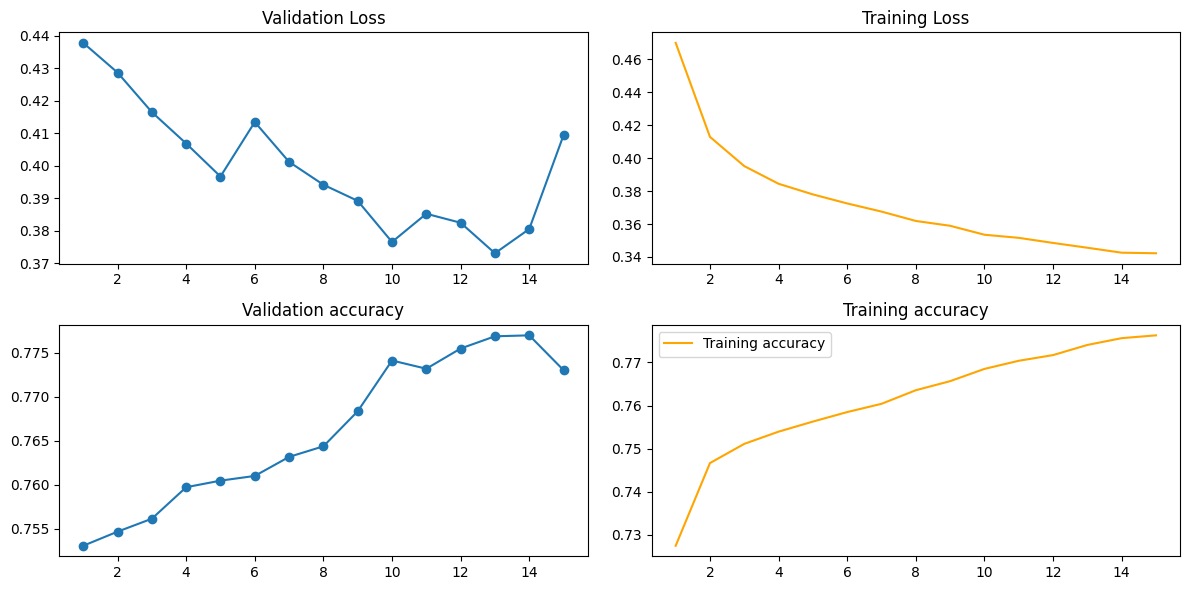

In [ ]:
plot_training(history7)

#### Class 8

In [ ]:
# create X and y dataframes
X_train = train.drop('attack_cat_code', axis=1)
y_train = train['attack_cat_code']

X_test = test.drop('attack_cat_code', axis=1)
y_test = test['attack_cat_code']

######### resampling
# get count of unique labels in the training fold
unique, counts = np.unique(train.attack_cat_code, return_counts=True)
counts = dict(zip(unique, counts))
print(f'Original counts:\n{counts}') # {0: 29600, 1: 15097, 2: 8905, 3: 4850, 4: 3271, 5: 2797, 6: 542, 7: 467, 8: 302, 9: 35}

# GET INITIAL LABEL COUNT
# get the count for the second largest label of #1 
# this will be the target ratio for upsamling the resto of the labels
zero = counts[0] 
one = counts[1]
two = counts[2]
target_ratio = {0: counts[3],
              1: counts[3],
              2: counts[2],
              3: counts[3],
              4: counts[4],
              5: counts[5],
              6: counts[6],
              7: counts[7], 
              8: counts[8],
              9: counts[9] }


# UNDERSAMPLE the majority class to match the rest of the labels
rus = RandomUnderSampler(sampling_strategy = target_ratio,
                        replacement = False)

X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

y_train_resampled.value_counts()

Original counts:
{0: 1885684, 1: 183159, 2: 37846, 3: 20609, 4: 13900, 5: 11889, 6: 2275, 7: 1980, 8: 1284, 9: 148}


2    37846
0    20609
1    20609
3    20609
4    13900
5    11889
6     2275
7     1980
8     1284
9      148
Name: attack_cat_code, dtype: int64

In [ ]:
# # get count of unique labels in the training fold
# unique, counts = np.unique(y_train_resampled, return_counts=True)
# counts = dict(zip(unique, counts))
# print(f'Original counts:\n{counts}') # {0: 29600, 1: 15097, 2: 8905, 3: 4850, 4: 3271, 5: 2797, 6: 542, 7: 467, 8: 302, 9: 35}

Original counts:
{0: 20609, 1: 20609, 2: 37846, 3: 20609, 4: 13900, 5: 11889, 6: 2275, 7: 1980, 8: 1284, 9: 148}


In [ ]:
######### resampling

# get count of unique labels in the training fold
unique, counts = np.unique(y_train_resampled, return_counts=True)
counts = dict(zip(unique, counts))
# print(f'Original counts:\n{counts}')

target_ratio2 =  {0: counts[0],
              1: counts[1],
              2: counts[2],
              3: counts[3],
              4: counts[4], 
              5: counts[5], 
              6: counts[6], 
              7: counts[7], 
              8: counts[1], # <<<<<<<<<<<<
              9: counts[9] }

# create SMOTE object
sm = SMOTE(sampling_strategy = target_ratio2)

# APPLY SMOTE on the train folds
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_resampled,
                                                       y_train_resampled)
y_train_resampled.value_counts()

2    37846
0    20609
1    20609
3    20609
8    20609
4    13900
5    11889
6     2275
7     1980
9      148
Name: attack_cat_code, dtype: int64

In [ ]:
###### mapping attack classes to binary case
y_train_resampled = y_train_resampled.apply(lambda x: 1 if x==8 else 0)

# splitting into train and val
X_train, X_val, y_train, y_val, = train_test_split(
    X_train_resampled, 
    y_train_resampled, 
    test_size=0.25, 
    random_state=42, 
    stratify=y_train_resampled)

# standardize the data
stdsc = StandardScaler()
# fit and transform train
X_train_std = stdsc.fit_transform(X_train)

# only transform test and val
X_test_std = stdsc.transform(X_test)
X_val_std = stdsc.transform(X_val)

# convert to float32
X_train_std = np.asarray(X_train_std).astype('float32')
X_test_std = np.asarray(X_test_std).astype('float32')
X_val_std = np.asarray(X_val_std).astype('float32')

# convert to float32 and reshape
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_val = np.asarray(y_val).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [ ]:
class_weights = {}
for val in np.unique(y_train):
    rows = y_train[y_train == val].shape[0]
    total = y_train.shape[0]
    weight = (1 / rows) * (total / 2.0)
    
    class_weights[val] = weight
class_weights 

{0.0: 0.579349678638165, 1.0: 3.6506113734877403}

In [ ]:
history8, model8 = create_model(X_train_std, y_train, class_weights)

Epoch 1/15
111/111 [==============================] - 4s 10ms/step - loss: 0.1418 - accuracy: 0.9537 - val_loss: 0.0444 - val_accuracy: 0.9900
Epoch 2/15
111/111 [==============================] - 1s 9ms/step - loss: 0.0453 - accuracy: 0.9876 - val_loss: 0.0315 - val_accuracy: 0.9923
Epoch 3/15
111/111 [==============================] - 1s 10ms/step - loss: 0.0358 - accuracy: 0.9905 - val_loss: 0.0309 - val_accuracy: 0.9922
Epoch 4/15
111/111 [==============================] - 1s 11ms/step - loss: 0.0300 - accuracy: 0.9916 - val_loss: 0.0305 - val_accuracy: 0.9924
Epoch 5/15
111/111 [==============================] - 1s 7ms/step - loss: 0.0291 - accuracy: 0.9915 - val_loss: 0.0281 - val_accuracy: 0.9929
Epoch 6/15
111/111 [==============================] - 1s 7ms/step - loss: 0.0274 - accuracy: 0.9918 - val_loss: 0.0273 - val_accuracy: 0.9927
Epoch 7/15
111/111 [==============================] - 1s 6ms/step - loss: 0.0264 - accuracy: 0.9920 - val_loss: 0.0284 - val_accuracy: 0.9926
Epo

In [ ]:
#generate predictions
y_pred8 = model8.predict(X_test_std)
all_preds[8] = y_pred8[:,1]
all_preds.head()

11906/11906 [==============================] - 29s 2ms/step


,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,8.695768e-03,1.977974e-08,0.206227,3.224547e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.0
1,0.0,0.0,1.348376e-02,1.595309e-03,0.030508,7.674504e-04,1.932565e-07,6.958081e-06,2.366830e-18,0.0
2,0.0,0.0,1.603530e-07,1.523220e-21,0.000129,0.000000e+00,0.000000e+00,2.561504e-13,2.863411e-22,0.0
3,0.0,0.0,1.182392e-03,1.213351e-07,0.000079,1.211057e-08,5.054508e-09,1.298711e-14,2.340054e-37,0.0
4,0.0,0.0,1.321613e-06,1.138505e-14,0.000373,3.562502e-28,0.000000e+00,9.149493e-13,1.464374e-23,0.0


<ipython-input-115-3d2be021db2a>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


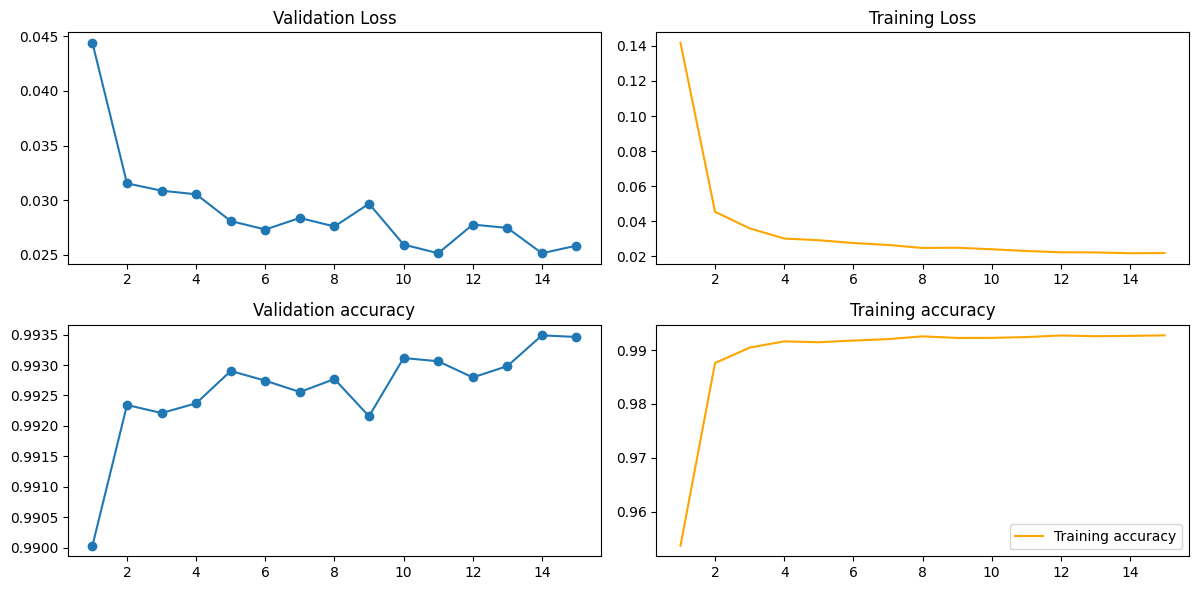

In [ ]:
plot_training(history8)

#### Class 9

In [ ]:
# create X and y dataframes
X_train = train.drop('attack_cat_code', axis=1)
y_train = train['attack_cat_code']

X_test = test.drop('attack_cat_code', axis=1)
y_test = test['attack_cat_code']

######### resampling
# get count of unique labels in the training fold
unique, counts = np.unique(train.attack_cat_code, return_counts=True)
counts = dict(zip(unique, counts))
print(f'Original counts:\n{counts}') # {0: 29600, 1: 15097, 2: 8905, 3: 4850, 4: 3271, 5: 2797, 6: 542, 7: 467, 8: 302, 9: 35}

# GET INITIAL LABEL COUNT
# get the count for the second largest label of #1 
# this will be the target ratio for upsamling the resto of the labels
zero = counts[0] 
one = counts[1]
two = counts[2]
target_ratio = {0: counts[3],
              1: counts[3],
              2: counts[2],
              3: counts[3],
              4: counts[4],
              5: counts[5],
              6: counts[6],
              7: counts[7], 
              8: counts[8],
              9: counts[9] }


# UNDERSAMPLE the majority class to match the rest of the labels
rus = RandomUnderSampler(sampling_strategy = target_ratio,
                        replacement = False)

X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

y_train_resampled.value_counts()

Original counts:
{0: 1885684, 1: 183159, 2: 37846, 3: 20609, 4: 13900, 5: 11889, 6: 2275, 7: 1980, 8: 1284, 9: 148}


2    37846
0    20609
1    20609
3    20609
4    13900
5    11889
6     2275
7     1980
8     1284
9      148
Name: attack_cat_code, dtype: int64

In [ ]:
# # get count of unique labels in the training fold
# unique, counts = np.unique(y_train_resampled, return_counts=True)
# counts = dict(zip(unique, counts))
# print(f'Original counts:\n{counts}') # {0: 29600, 1: 15097, 2: 8905, 3: 4850, 4: 3271, 5: 2797, 6: 542, 7: 467, 8: 302, 9: 35}

Original counts:
{0: 20609, 1: 20609, 2: 37846, 3: 20609, 4: 13900, 5: 11889, 6: 2275, 7: 1980, 8: 1284, 9: 148}


In [ ]:
######### resampling

# get count of unique labels in the training fold
unique, counts = np.unique(y_train_resampled, return_counts=True)
counts = dict(zip(unique, counts))
# print(f'Original counts:\n{counts}')

target_ratio2 =  {0: counts[0],
              1: counts[1],
              2: counts[2],
              3: counts[3],
              4: counts[4], 
              5: counts[5], 
              6: counts[6], 
              7: counts[7], 
              8: counts[8],
              9: counts[1] # <<<<<<<<<<<<
              }

# create SMOTE object
sm = SMOTE(sampling_strategy = target_ratio2)

# APPLY SMOTE on the train folds
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_resampled,
                                                       y_train_resampled)
y_train_resampled.value_counts()

2    37846
0    20609
1    20609
3    20609
9    20609
4    13900
5    11889
6     2275
7     1980
8     1284
Name: attack_cat_code, dtype: int64

In [ ]:
###### mapping attack classes to binary case
y_train_resampled = y_train_resampled.apply(lambda x: 1 if x==9 else 0)

# splitting into train and val
X_train, X_val, y_train, y_val, = train_test_split(
    X_train_resampled, 
    y_train_resampled, 
    test_size=0.25, 
    random_state=42, 
    stratify=y_train_resampled)

# standardize the data
stdsc = StandardScaler()
# fit and transform train
X_train_std = stdsc.fit_transform(X_train)

# only transform test and val
X_test_std = stdsc.transform(X_test)
X_val_std = stdsc.transform(X_val)

# convert to float32
X_train_std = np.asarray(X_train_std).astype('float32')
X_test_std = np.asarray(X_test_std).astype('float32')
X_val_std = np.asarray(X_val_std).astype('float32')

# convert to float32 and reshape
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_val = np.asarray(y_val).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [ ]:
class_weights = {}
for val in np.unique(y_train):
    rows = y_train[y_train == val].shape[0]
    total = y_train.shape[0]
    weight = (1 / rows) * (total / 2.0)
    
    class_weights[val] = weight
class_weights 

{0.0: 0.5786615776081424, 1.0: 3.678171702141425}

In [ ]:
history9, model9 = create_model(X_train_std, y_train, class_weights)

Epoch 1/15
112/112 [==============================] - 4s 10ms/step - loss: 0.3077 - accuracy: 0.8509 - val_loss: 0.2363 - val_accuracy: 0.9014
Epoch 2/15
112/112 [==============================] - 1s 7ms/step - loss: 0.1958 - accuracy: 0.9074 - val_loss: 0.1806 - val_accuracy: 0.9235
Epoch 3/15
112/112 [==============================] - 1s 10ms/step - loss: 0.1538 - accuracy: 0.9278 - val_loss: 0.1449 - val_accuracy: 0.9348
Epoch 4/15
112/112 [==============================] - 1s 6ms/step - loss: 0.1212 - accuracy: 0.9421 - val_loss: 0.1024 - val_accuracy: 0.9593
Epoch 5/15
112/112 [==============================] - 1s 5ms/step - loss: 0.1008 - accuracy: 0.9530 - val_loss: 0.0905 - val_accuracy: 0.9606
Epoch 6/15
112/112 [==============================] - 1s 8ms/step - loss: 0.0905 - accuracy: 0.9589 - val_loss: 0.0896 - val_accuracy: 0.9648
Epoch 7/15
112/112 [==============================] - 1s 7ms/step - loss: 0.0810 - accuracy: 0.9629 - val_loss: 0.0784 - val_accuracy: 0.9703
Epoc

In [ ]:
#generate predictions
y_pred9 = model9.predict(X_test_std)
all_preds[9] = y_pred9[:,1]
all_preds.head()

11906/11906 [==============================] - 27s 2ms/step


,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,8.695768e-03,1.977974e-08,0.206227,3.224547e-03,0.000000e+00,0.000000e+00,0.000000e+00,2.864321e-35
1,0.0,0.0,1.348376e-02,1.595309e-03,0.030508,7.674504e-04,1.932565e-07,6.958081e-06,2.366830e-18,7.044948e-18
2,0.0,0.0,1.603530e-07,1.523220e-21,0.000129,0.000000e+00,0.000000e+00,2.561504e-13,2.863411e-22,0.000000e+00
3,0.0,0.0,1.182392e-03,1.213351e-07,0.000079,1.211057e-08,5.054508e-09,1.298711e-14,2.340054e-37,0.000000e+00
4,0.0,0.0,1.321613e-06,1.138505e-14,0.000373,3.562502e-28,0.000000e+00,9.149493e-13,1.464374e-23,0.000000e+00


<ipython-input-115-3d2be021db2a>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


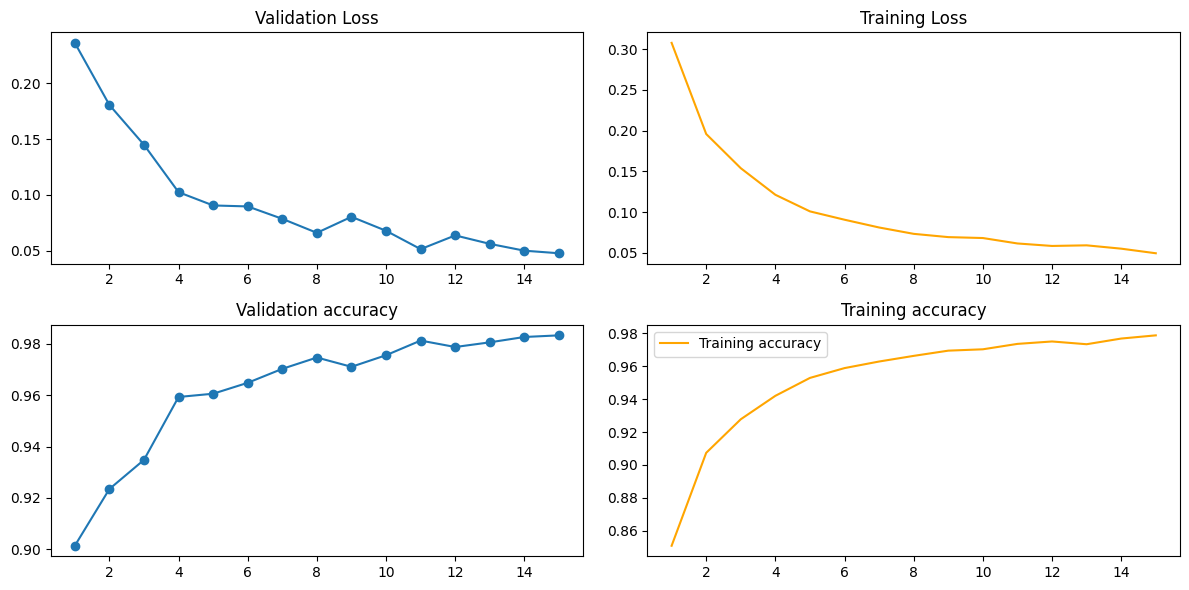

In [ ]:
plot_training(history9)

#### Analyzing Predictions

In [ ]:
complete_predictions = all_preds.copy()
complete_predictions.head()

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.073562,8.695768e-03,1.977974e-08,0.206227,3.224547e-03,0.000000e+00,0.000000e+00,0.000000e+00,2.864321e-35
1,0.999879,0.000297,1.348376e-02,1.595309e-03,0.030508,7.674504e-04,1.932565e-07,6.958081e-06,2.366830e-18,7.044948e-18
2,1.000000,0.000030,1.603530e-07,1.523220e-21,0.000129,0.000000e+00,0.000000e+00,2.561504e-13,2.863411e-22,0.000000e+00
3,1.000000,0.000118,1.182392e-03,1.213351e-07,0.000079,1.211057e-08,5.054508e-09,1.298711e-14,2.340054e-37,0.000000e+00
4,1.000000,0.000052,1.321613e-06,1.138505e-14,0.000373,3.562502e-28,0.000000e+00,9.149493e-13,1.464374e-23,0.000000e+00


In [ ]:
complete_predictions.to_csv('ova_preds.csv', index = False)

In [ ]:
y_test = test['attack_cat_code']
y_test.to_csv('y_test.csv', index = False)

In [ ]:
complete_predictions.shape

(380961, 10)

In [ ]:
y_pred_collapsed = tf.argmax(input=complete_predictions, axis=1)
y_pred_collapsed[:20]

<tf.Tensor: shape=(20,), dtype=int64, numpy=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])>

Accuracy:0.97
Balanced accuracy:0.77
Precision:0.98
Recall:0.97
F1-score:0.98


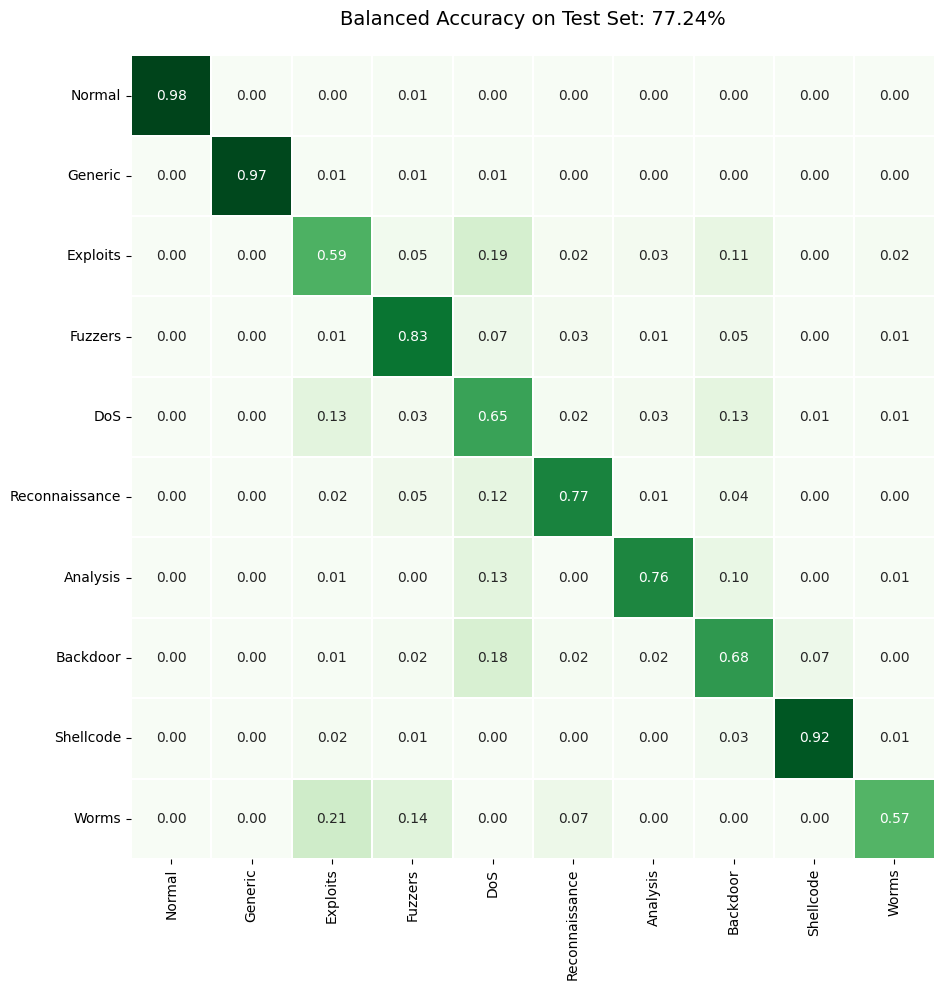

Classification Report:
                 precision    recall  f1-score   support

        Normal       1.00      0.98      0.99    135296
       Generic       1.00      0.97      0.99     13285
      Exploits       0.79      0.59      0.67      2719
       Fuzzers       0.41      0.83      0.55      1466
           DoS       0.42      0.65      0.51       981
Reconnaissance       0.78      0.77      0.77       857
      Analysis       0.25      0.76      0.38       157
      Backdoor       0.12      0.68      0.21       133
     Shellcode       0.30      0.92      0.46        91
         Worms       0.06      0.57      0.12        14

      accuracy                           0.97    154999
     macro avg       0.51      0.77      0.56    154999
  weighted avg       0.98      0.97      0.98    154999



(0.9704901321944013,
 0.7723901808586975,
 0.9837711335129329,
 0.9704901321944013,
 0.9755469529878998)

In [134]:
calculate_metrics(y_test, y_pred_collapsed, labels)